## Data augmentation for machine learning

In [1]:
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("processed_jobs.csv")

### 1. Deal with missing data

- Find all columns with missing values

In [3]:
ds_na = df.isna().sum()
ds_na = ds_na[ds_na>0].sort_values()

In [4]:
ds_na

job_description                  2
company_name                     2
inferred_country               160
city                           454
country                       1370
state                         4354
segment_name                  4724
inferred_iso3_lang_code       7019
inferred_state                8758
skills                        9577
inferred_salary_currency     11622
html_job_description         14796
inferred_salary_from         14800
inferred_salary_to           14939
average_salary_raw           14964
time_unit_factor             15025
inferred_salary_time_unit    15025
average_annual_salary        15193
salary_level                 15315
inferred_city                17868
test_contact_email           21486
contact_email                21486
inferred_iso2_lang_code      27971
job_post_lang                27971
salary_offered               29231
company_description          29909
dtype: int64

- Fill missing data for country, state and city

country

In [5]:
df.country.fillna("UK", inplace=True)
df.inferred_country.fillna("United kingdom", inplace=True)

state

In [6]:
df.loc[df.state.isnull(), "state"] = df.loc[df.state.isnull(), "inferred_state"]
df.loc[df.inferred_state.isnull(), "inferred_state"] = df.loc[df.inferred_state.isnull(), "state"]

In [7]:
df.state.fillna("England", inplace=True)
df.inferred_state.fillna("England", inplace=True)

city

In [8]:
df.loc[df.city.isnull(), "city"] = df.loc[df.city.isnull(), "inferred_city"]
df.loc[df.inferred_city.isnull(), "inferred_city"] = df.loc[df.inferred_city.isnull(), "city"]

In [9]:
df.city.fillna("Other", inplace=True)
df.inferred_city.fillna("Other", inplace=True)

- Fill missing data for salary

In [10]:
df.inferred_salary_currency.fillna("GBP", inplace=True)

fill missing salary with median data

In [11]:
median_salary = df.average_annual_salary.median()
df["salary_na_median"] = df.average_annual_salary.fillna(median_salary)

fill missing salary with general title

In [12]:
df_s = df[(df.error_data==False)&(df.average_annual_salary<1000000)]

In [13]:
median_titles = df_s.groupby("general_title")["average_annual_salary"].median()
title_median_salary_dict = dict(median_titles)

In [14]:
df["salary_na_title"] = df["average_annual_salary"].copy()
df.loc[df.salary_na_title.isna(), "salary_na_title"] = df.loc[df.salary_na_title.isna(), "general_title"].map(title_median_salary_dict)

fill missing salary with probability distribution

Statistical modeling - find the proper probability distribution

/Users/qiuruihao/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/qiuruihao/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/qiuruihao/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


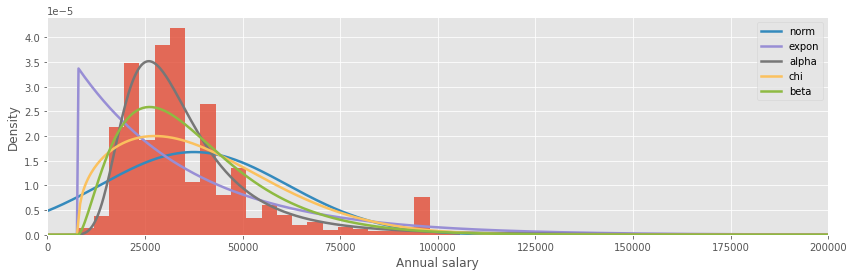

In [15]:
plt.figure(figsize=(14,4))

plt.xlabel('Annual salary')
plt.ylabel('Density')

plt.hist(df_s.average_annual_salary, density=True, bins=150, alpha=0.8)

dist_2 = ["norm", "expon"]
dist_3 = ["alpha", "chi"]
dist_4 = ["beta"]

data = df_s.average_annual_salary

for d in dist_2:
    dist = getattr(stats, d)
    parameters = dist.fit(data)

    x = np.linspace(0, 200000, 500)
    y = dist.pdf(x, parameters[0], parameters[1])

    plt.plot(x, y, lw=2.5, label=d)


for d in dist_3:
    dist = getattr(stats, d)
    parameters = dist.fit(data)

    x = np.linspace(0, 200000, 500)
    y = dist.pdf(x, parameters[0], parameters[1], parameters[2])

    plt.plot(x, y, lw=2.5, label=d)
    
for d in dist_4:
    dist = getattr(stats, d)
    parameters = dist.fit(data)

    x = np.linspace(0, 200000, 500)
    y = dist.pdf(x, parameters[0], parameters[1], parameters[2], parameters[3])

    plt.plot(x, y, lw=2.5, label=d)


plt.xlim(0, 200000)

plt.legend()
plt.show()

Random sampling from the distribution

In [16]:
from scipy.stats import alpha
parameters = alpha.fit(data)
a, n_min, scale = parameters

/Users/qiuruihao/opt/miniconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [17]:
df["salary_na_dist"] = df["average_annual_salary"].copy()
n_null = df.salary_na_dist.isna().sum()
df.loc[df.salary_na_dist.isna(), "salary_na_dist"] = alpha.rvs(a, size=n_null) * scale + n_min

$\color{white}{\text{PLEASE SUBMIT YOUR OWN SOLUTIONS}}$